In [1]:
import torch 
from torch import nn

import torchvision 
from torchvision import transforms , datasets , models
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt


In [2]:
train_data = datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:17<00:00, 1516288.57it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 335072.51it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:10<00:00, 427684.84it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5144693.11it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

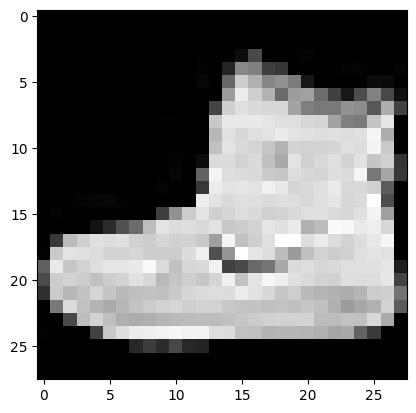

In [9]:
plt.imshow(image.permute(1,2,0), "gray")

In [11]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

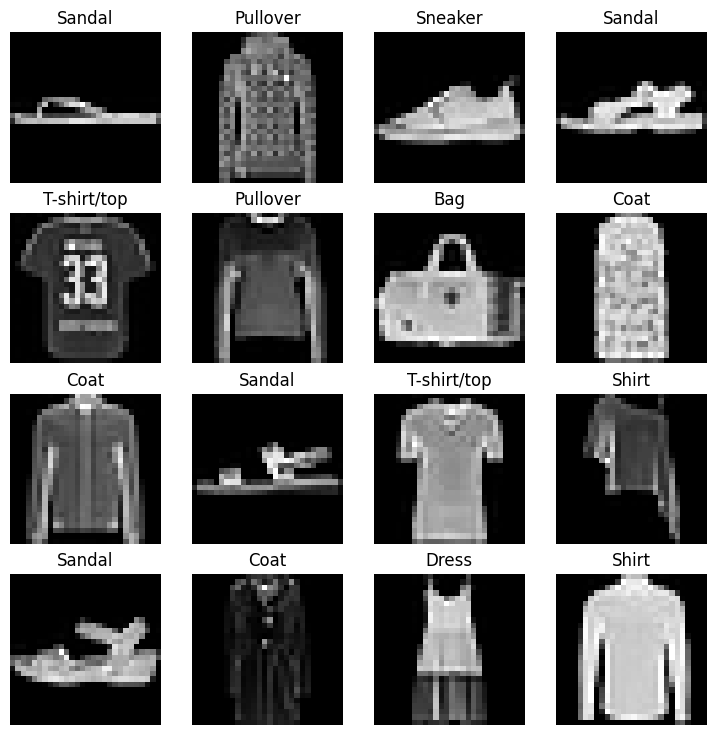

In [17]:
cols, rows = 4,4
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0), "gray")
    plt.title(class_names[label])
    plt.axis(False)

In [118]:
train_loader = DataLoader(train_data, 32, True)
test_loader = DataLoader(test_data, 32, True)

In [119]:
print(len(train_loader), len(test_loader))

1875 313


In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [121]:
class MNISTModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 10),
            nn.Linear(10, 10)
        )
    def forward(self, X):
        return self.l1(X)

In [122]:
model_0 = MNISTModelV0().to(device)
model_0

MNISTModelV0(
  (l1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [123]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.0333,  0.0314,  0.0320,  ..., -0.0038,  0.0017, -0.0104],
        [ 0.0096, -0.0193,  0.0178,  ..., -0.0164,  0.0164, -0.0260],
        [ 0.0106,  0.0289,  0.0277,  ..., -0.0102, -0.0089,  0.0169],
        ...,
        [-0.0058,  0.0163,  0.0219,  ...,  0.0006, -0.0219,  0.0326],
        [ 0.0094, -0.0139,  0.0113,  ...,  0.0284,  0.0085, -0.0186],
        [-0.0087, -0.0153, -0.0222,  ...,  0.0126, -0.0048, -0.0293]],
       device='cuda:0', requires_grad=True)

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [125]:
img, label = next(iter(test_loader))
img, label = img.to(device), label.to(device)
img.shape, label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [126]:
img.device

device(type='cuda', index=0)

In [127]:
model_0.eval()
with torch.inference_mode():
    pretrain_pred = torch.softmax(model_0(img), dim=1)
    

torch.argmax(pretrain_pred,dim=1),label

(tensor([7, 8, 8, 7, 7, 7, 5, 7, 8, 7, 7, 8, 5, 8, 8, 8, 5, 7, 7, 7, 5, 7, 7, 8,
         5, 7, 7, 8, 8, 8, 7, 8], device='cuda:0'),
 tensor([5, 0, 1, 9, 5, 3, 6, 3, 0, 4, 0, 2, 7, 4, 1, 6, 7, 0, 3, 8, 2, 6, 3, 6,
         2, 9, 7, 4, 1, 3, 9, 1], device='cuda:0'))

In [128]:
from sklearn.metrics import accuracy_score

In [129]:
from tqdm.auto import tqdm

In [137]:
torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    
    print(f'Epoch: {epoch} |......')

    for batch,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        model_0.train()
        logits = model_0(images)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(images)}/{len(train_loader.dataset)} samples.")
        
        model_0.eval()

    with torch.inference_mode():
        for images_, labels_ in test_loader:
            images_, labels_ = images_.to(device), labels_.to(device)

            test_logits = model_0(images_)
            test_pred = torch.argmax(test_logits, dim=1)
            test_loss = criterion(test_logits, labels_)
      



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 |......
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


KeyboardInterrupt: 

In [136]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
# train_time_start_on_cpu = timer() 

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  # train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)
    
    # 2. Calculate loss (per batch)
    loss = criterion(y_pred, y)
    # train_loss += loss # accumulate train loss
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
    
    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
  
  # Divide total train loss by length of train dataloader
  # train_loss /= len(train_loader)

  ### Testing
  # test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode(): 
    for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      # test_loss += criterion(test_pred, y_test)

      # 3. Calculate accuracy
      # test_acc += accuracy_score(y_true=y_test.cpu().detach(), y_pred=test_pred.argmax(dim=1).cpu().detach())

    # Calculate the test loss average per batch
    # test_loss /= len(test_loader)

    # Calculate the test acc average per batch
    # test_acc /= len(test_loader)

  # Print out what's happening
  # print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training tim

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


In [61]:
torch.mean(torch.tensor(acc_mat)).item()

0.3973684310913086

In [ ]:
208.35/60

[[...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],


In [207]:
class MNISTModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            # nn.ReLU(),
            nn.Linear(10, 10),
            # nn.ReLU(),
            # nn.Softmax(dim=1)
        )
    def forward(self, X):
        return self.l1(X)

In [208]:
model_1 = MNISTModelV0().to(device)
model_1

MNISTModelV0(
  (l1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [209]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [334]:
def Train_model(
        model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn,
        optimizer,
        acc_fn,
        device:torch.device=device):
    # put model to Train
    model.train()

    #iniate loss and acc sum var
    train_loss, train_acc= 0, 0

    #start looping on epochs
    
        
        #looping over Data_Loader
    for X, y in data_loader:

        #put data into processing device 
        X, y = X.to(device), y.to(device)

        #Get Model predictions
        pred = model(X)
        
        #compute the current Loss and Acc
        loss = loss_fn(pred, y)
        train_loss+=loss
        # print(acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach()))
        train_acc += acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach())

        #Reset optimizer to Zero
        optimizer.zero_grad()

        #Compute the Gradient
        loss.backward()
        
        # Back Propagate step
        optimizer.step()
    train_loss /=len(data_loader)
    train_acc  /=len(data_loader)

    return f"Train_Loss: {train_loss} | Train_Acc: {train_acc}"

def Test_model(
        model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn,
        acc_fn,
        device:torch.device=device):
    # put model to Train
    model.eval()

    #iniate loss and acc sum var
    test_loss, test_acc= 0, 0

    #start looping on epochs
    
        
        #looping over Data_Loader
    for X, y in data_loader:

        #put data into processing device 
        X, y = X.to(device), y.to(device)

        #Get Model predictions
        pred = model(X)
        
        #compute the current Loss and Acc
        loss = loss_fn(pred, y)
        test_loss+=loss
        # print(acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach()))
        test_acc += acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach())

    test_loss /=len(data_loader)
    test_acc  /=len(data_loader)

    return f"Test_Loss: {test_loss} | Test_Acc: {test_acc}"

In [211]:
epochs=3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}......")
    print(Train_model(model_1, train_loader, criterion, optimizer, accuracy_score, device))
    print(Test_model(model_1, test_loader, criterion, accuracy_score, device))

print("#"*30,"\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0......
Train_Loss: 0.5871223211288452 | Train_Acc: 0.7932833333333333
Test_Loss: 0.5661868453025818 | Test_Acc: 0.7973242811501597
Epoch: 1......
Train_Loss: 0.4769175052642822 | Train_Acc: 0.8321333333333333
Test_Loss: 0.5102934837341309 | Test_Acc: 0.8207867412140575
Epoch: 2......
Train_Loss: 0.45468246936798096 | Train_Acc: 0.8403166666666667
Test_Loss: 0.4864463210105896 | Test_Acc: 0.8332667731629393
############################## 



In [220]:
X= next(iter(train_loader))

In [223]:
X[0][0].shape

torch.Size([1, 28, 28])

In [335]:
class MNISTModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 4, padding=1), #27
            nn.ReLU(),
            nn.Conv2d(10, 10, 6, padding=1), #24
            nn.ReLU(),
            nn.Conv2d(10, 10, 6, padding=1), #21
            nn.ReLU()
        )
        self.fc1= nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*21*21, 10),
            nn.Linear(10, 10),
            # nn.Softmax(dim=1)
        )
    def forward(self, X):
        z= self.conv1(X)
        z= self.fc1(z)
        return z

In [336]:
model_final = MNISTModelV2().to(device)
model_final

MNISTModelV2(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4410, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [337]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_final.parameters(), lr=0.1)

In [338]:
epochs=8
for epoch in tqdm(range(epochs)):
    print("#"*20, f"Epoch: {epoch}", "#"*20)

    print(Train_model(
        model_final, 
        train_loader, 
        criterion, 
        optimizer, 
        accuracy_score,
        device,
    ))
    print(Test_model(
        model_final,
        test_loader,
        criterion,
        accuracy_score,
        device,
    ))

  0%|          | 0/8 [00:00<?, ?it/s]

#################### Epoch: 0 ####################
Train_Loss: 0.5818118453025818 | Train_Acc: 0.78275
Test_Loss: 0.4033272862434387 | Test_Acc: 0.8528354632587859
#################### Epoch: 1 ####################
Train_Loss: 0.365448534488678 | Train_Acc: 0.86615
Test_Loss: 0.35508161783218384 | Test_Acc: 0.8717052715654952
#################### Epoch: 2 ####################
Train_Loss: 0.3190988302230835 | Train_Acc: 0.8829833333333333
Test_Loss: 0.36206942796707153 | Test_Acc: 0.8692092651757188
#################### Epoch: 3 ####################
Train_Loss: 0.2901938557624817 | Train_Acc: 0.8924833333333333
Test_Loss: 0.32243016362190247 | Test_Acc: 0.8796924920127795
#################### Epoch: 4 ####################
Train_Loss: 0.26996225118637085 | Train_Acc: 0.9012166666666667
Test_Loss: 0.32098400592803955 | Test_Acc: 0.8806908945686901
#################### Epoch: 5 ####################
Train_Loss: 0.2564259171485901 | Train_Acc: 0.90615
Test_Loss: 0.3245583176612854 | Test_Acc

In [339]:
imgs, labels = next(iter(test_loader))
imgs = imgs.to(device)
model_final.eval()
with torch.inference_mode():
    pred= model_final(imgs).argmax(dim=1)
pred

tensor([9, 3, 7, 0, 8, 8, 0, 2, 6, 5, 8, 9, 1, 5, 1, 8, 8, 8, 6, 4, 5, 5, 7, 8,
        7, 6, 3, 9, 5, 5, 7, 8], device='cuda:0')

In [340]:
labels

tensor([9, 3, 9, 0, 8, 8, 0, 2, 6, 5, 8, 9, 1, 5, 1, 2, 8, 8, 0, 0, 5, 5, 7, 8,
        9, 6, 3, 9, 5, 5, 7, 8])

In [341]:
import random
import math

In [342]:
samples = []
labels = []
for i in range(9):
    img, label = test_data[random.randint(0, len(test_data))]
    samples.append(img)
    labels.append(label)

In [343]:
model_final.eval()
predictions=[]
with torch.inference_mode():
    for i in range(len(samples)):
        pred= model_final(samples[i].unsqueeze(0).to(device))
        predictions.append(torch.softmax(pred, dim=1).argmax(dim=1).cpu().item())



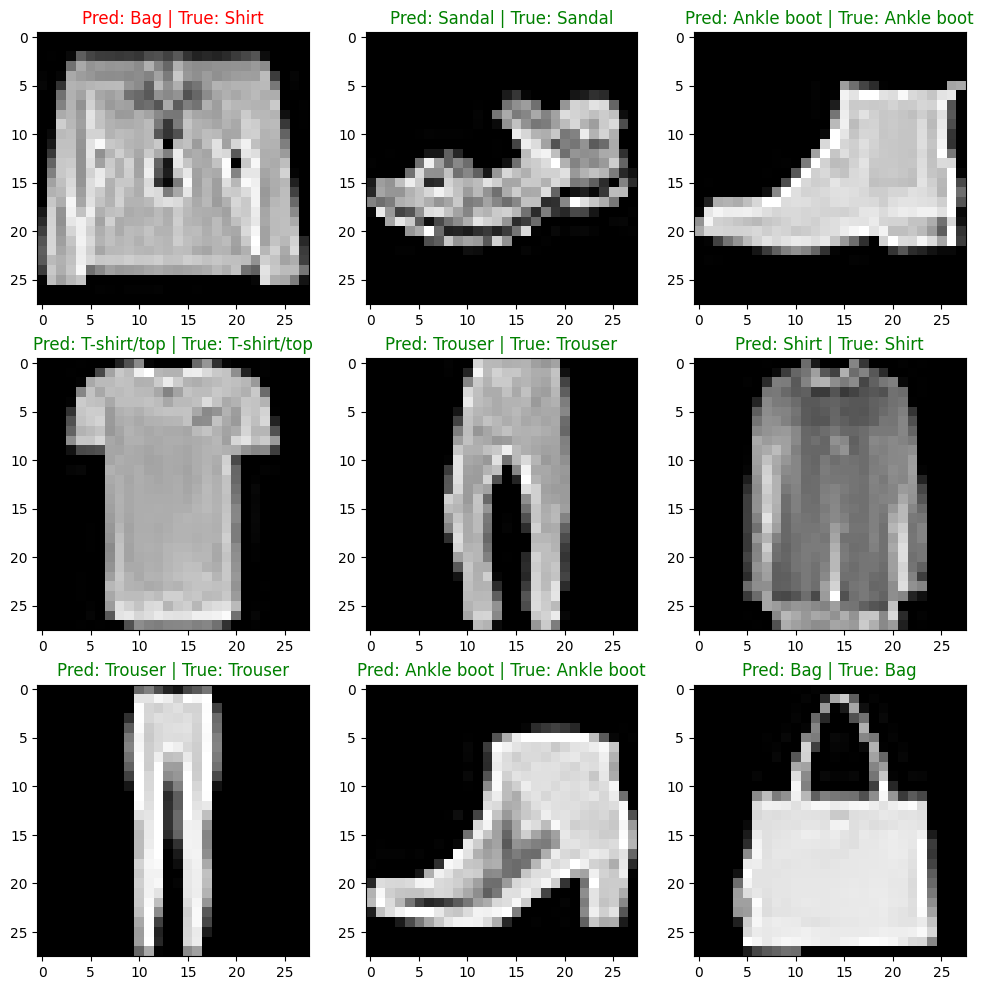

In [344]:
fig = plt.figure(figsize=(12,12))
cols = math.ceil(math.sqrt(9))
rows = math.floor(math.sqrt(9))
for i in range(1,9+1):
    plt.subplot(rows, cols, i)
    plt.imshow(samples[i-1].permute(1,2,0), "gray")
    
    txt = f"Pred: {class_names[predictions[i-1]]} | True: {class_names[labels[i-1]]}"
    if predictions[i-1] == labels[i-1]:
        plt.title(txt, c="g")
    else:
        plt.title(txt, c="r")

In [267]:
math.ceil(math.sqrt(10))

3.1622776601683795